# Olist's Metric Design 

In this challenge, we are going to catch a first glimpse into `Olist's business health`

In [2]:
# Import Modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Loading the data
from olist.data import Olist
data = Olist().get_data()
print(data)

{'sellers':                              seller_id  seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                   13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166                   87111   
3091  f8201cab383e484733266d1906e2fdfa                   88137   
3092  74871d19219c7d518d0090283e03c137                    4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  


## Test your import!

In [4]:
from nbresult import ChallengeResult

result = ChallengeResult('orders',
    keys_len=len(data),
    key_names=sorted(list(data.keys())),
    reviews_number=len(data['order_reviews'])
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/francoisgirard/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/francoisgirard/code/francoisgirard51/04-Decision-Science/01-Project-Setup/data-optional-metric-design/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 3 items

test_orders.py::TestOrders::test_key_names PASSED                        [ 33%]
test_orders.py::TestOrders::test_keys_len PASSED                         [ 66%]
test_orders.py::TestOrders::test_reviews_number PASSED                   [100%]

============================== 3 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/orders.pickle

git commit -m 'Completed orders step'

git push origin master



## 1 - Orders vs. Reviews?

❓Plot a histogram of `review_score`. 

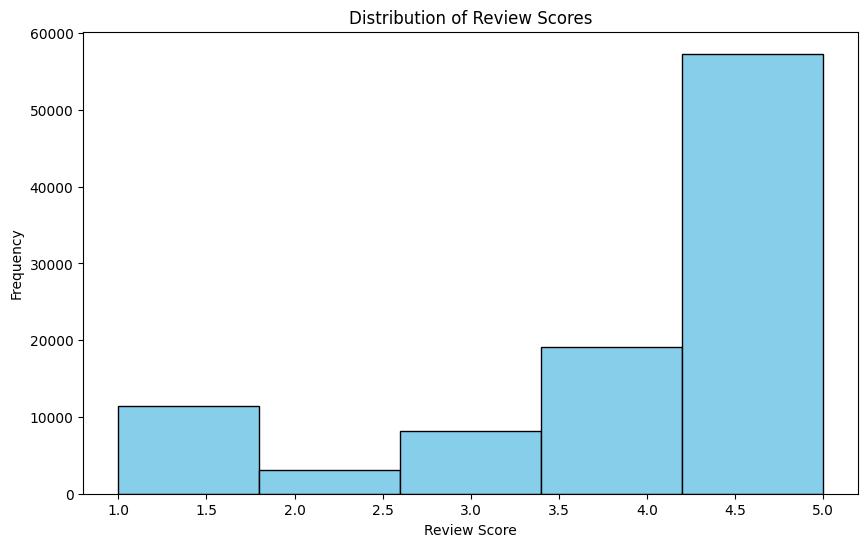

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(data['order_reviews']['review_score'], bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

❓ Plot a histogram of `order_status` <br/>

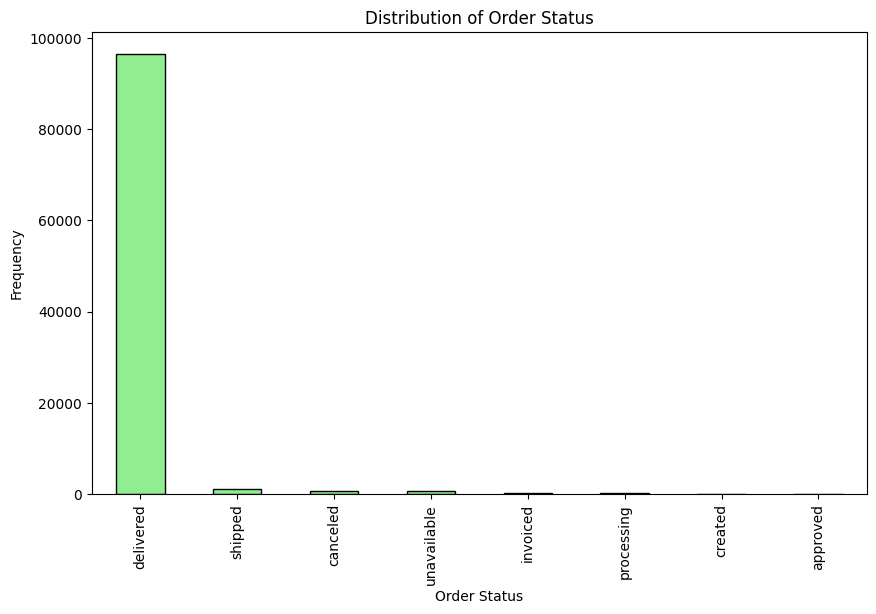

In [8]:
plt.figure(figsize=(10, 6))
data['orders']['order_status'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Distribution of Order Status')
plt.xlabel('Order Status')
plt.ylabel('Frequency')
plt.show()

❓ How many of them are delivered ? shipped ? canceled ? ...

In [9]:
order_status_counts = data['orders']['order_status'].value_counts()
print(order_status_counts)

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


💡 We already know - from our data schema - that each `review` has a unique `order`.

🤔 Do all `orders` have a `review`?

<details>
    <summary><i>▸ Hint</i></summary>

You can use `pd.Series.isna().sum()` to count the number of NaN values in a series
</details>

In [10]:
# Merging orders and reviews DataFrames on 'order_id'
merged_data = pd.merge(data['orders'], data['order_reviews'], on='order_id', how='left')

# Counting the number of orders without a review
n_orders_without_review = merged_data['review_id'].isna().sum()
print(f"Number of orders without a review: {n_orders_without_review}")

Number of orders without a review: 768


If some orders were not reviewed, count and group them per `order_status`.

In [11]:
# Filtering orders without a review
orders_without_review = merged_data[merged_data['review_id'].isna()]

# Grouping by order_status and counting
orders_without_review_status = orders_without_review['order_status'].value_counts()
print(orders_without_review_status)

delivered      646
shipped         75
canceled        20
unavailable     14
processing       6
invoiced         5
created          2
Name: order_status, dtype: int64


## 2 - Evolution of key business metrics over the past 14 months

## Metrics 

1. Which metric would you use as a `key business output metric`for Olist  📈 ? 
2.  Which metric would you use to measure that a customer had a `good experience with Olist` 🙂 ? 
3. Which metric would you use to measure `shipping delay` 🕗?

For each metric, plot a trend line over time.

### Metric 1: Order numbers

❓ Plot the weekly number of total orders per week (to check how business is going)  


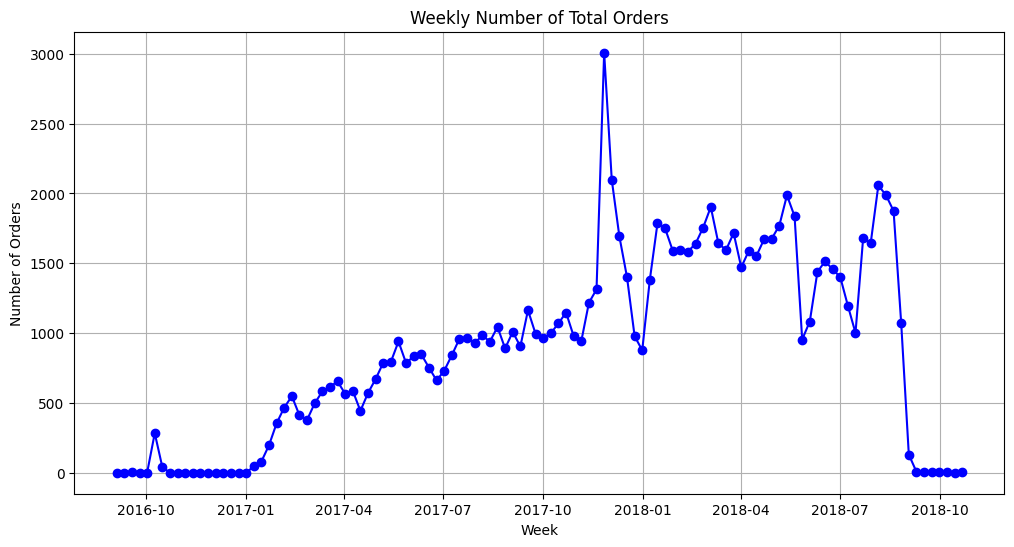

In [19]:
# Convert 'order_approved_at' to datetime if not already done
data['orders']['order_approved_at'] = pd.to_datetime(data['orders']['order_approved_at'])

# Set the index to the approved timestamp
data['orders'].set_index('order_approved_at', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(weekly_orders.index, weekly_orders, marker='o', linestyle='-', color='blue')
plt.title('Weekly Number of Total Orders')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

❓ Visualize the weekly number of non-delivered orders (to check for any potential issues)

<details>
    <summary><i>▸ Hint </i></summary>    
    
* Convert dates to Python `datetime` objects  
* You can use the built-in `pandas.Series.resample() tool from `pandas` to group your dataset by weeks
    
</details>

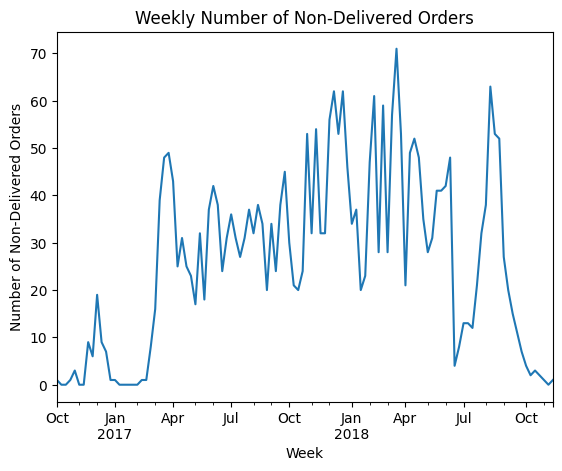

In [27]:
# Convert 'order_estimated_delivery_date' to datetime if not already done
data['orders']['order_estimated_delivery_date'] = pd.to_datetime(data['orders']['order_estimated_delivery_date'])

# Filter the dataset for non-delivered orders
# Adjust the condition as necessary for your specific context
non_delivered_orders = data['orders'][data['orders']['order_delivered_customer_date'].isna()]

# Set the index to the estimated delivery date
non_delivered_orders.set_index('order_estimated_delivery_date', inplace=True)

# Resample to get weekly counts of non-delivered orders
weekly_non_delivered = non_delivered_orders.resample('W').size()

# Plot the weekly number of non-delivered orders
weekly_non_delivered.plot(title='Weekly Number of Non-Delivered Orders')
plt.xlabel('Week')
plt.ylabel('Number of Non-Delivered Orders')
plt.show()

### Metric 1-bis (optional): Total payment values
❓ After plotting the total number of orders, we could also have a look at the weekly sum of `payment_value` in `BRL` to approximate Olist's weekly revenues.

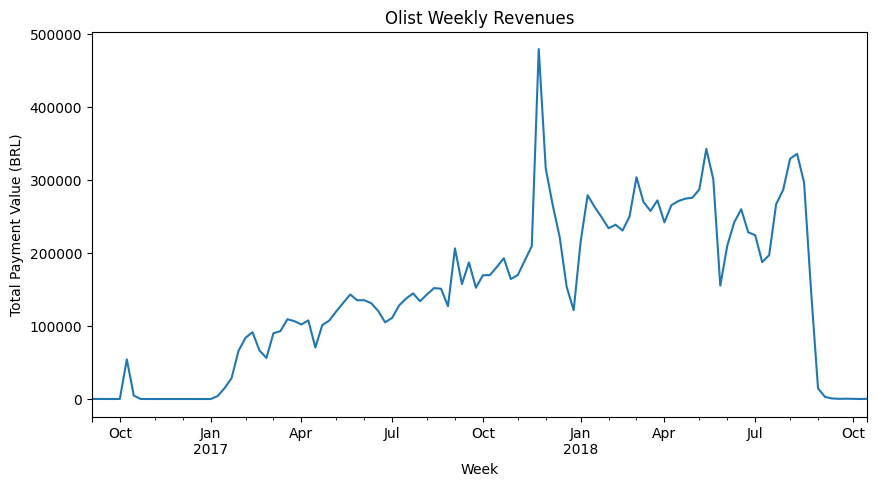

In [38]:
# Convert the 'order_purchase_timestamp' to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Merge the 'orders' DataFrame with 'order_payments' on 'order_id'
merged_df = pd.merge(order_payments, orders[['order_id', 'order_purchase_timestamp']], on='order_id')

# Set the 'order_purchase_timestamp' as the index of the merged DataFrame
merged_df.set_index('order_purchase_timestamp', inplace=True)

# Resample the data to get weekly sums of 'payment_value'
weekly_revenues = merged_df['payment_value'].resample('W').sum()

# Plotting the weekly revenues
plt.figure(figsize=(10, 5))
weekly_revenues.plot(kind='line', title='Olist Weekly Revenues')
plt.xlabel('Week')
plt.ylabel('Total Payment Value (BRL)')
plt.show()

💡 Merge the `payments` dataset with the `orders` dataset to collect the date of each payment.

In [39]:
# Convert the 'order_purchase_timestamp' to datetime in the 'orders' dataset
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Merge the 'order_payments' DataFrame with the 'orders' DataFrame on 'order_id'
merged_df = pd.merge(order_payments, orders[['order_id', 'order_purchase_timestamp']], on='order_id')

# Display the first few rows of the merged DataFrame
print(merged_df.head())

                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value order_purchase_timestamp  
0                     8          99.33      2018-04-25 22:01:49  
1                     1          24.39      2018-06-26 11:01:38  
2                     1          65.71      2017-12-12 11:19:55  
3                     8         107.78      2017-12-06 12:04:06  
4                     2         128.45      2018-05-21 13:59:17  


⌛️ Once again, do not forget to handle datetimes properly

In [40]:
# Ensure that 'order_purchase_timestamp' in the 'orders' dataset is in datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Merge the 'order_payments' DataFrame with the 'orders' DataFrame on 'order_id'
# This will allow us to have the payment dates (timestamps) alongside the payment values
merged_df = pd.merge(order_payments, orders[['order_id', 'order_purchase_timestamp']], on='order_id')

# Display the first few rows of the merged DataFrame to verify the merge and datetime handling
print(merged_df.head())

                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value order_purchase_timestamp  
0                     8          99.33      2018-04-25 22:01:49  
1                     1          24.39      2018-06-26 11:01:38  
2                     1          65.71      2017-12-12 11:19:55  
3                     8         107.78      2017-12-06 12:04:06  
4                     2         128.45      2018-05-21 13:59:17  


📈 Visualize the number of orders and total amount of payments per week

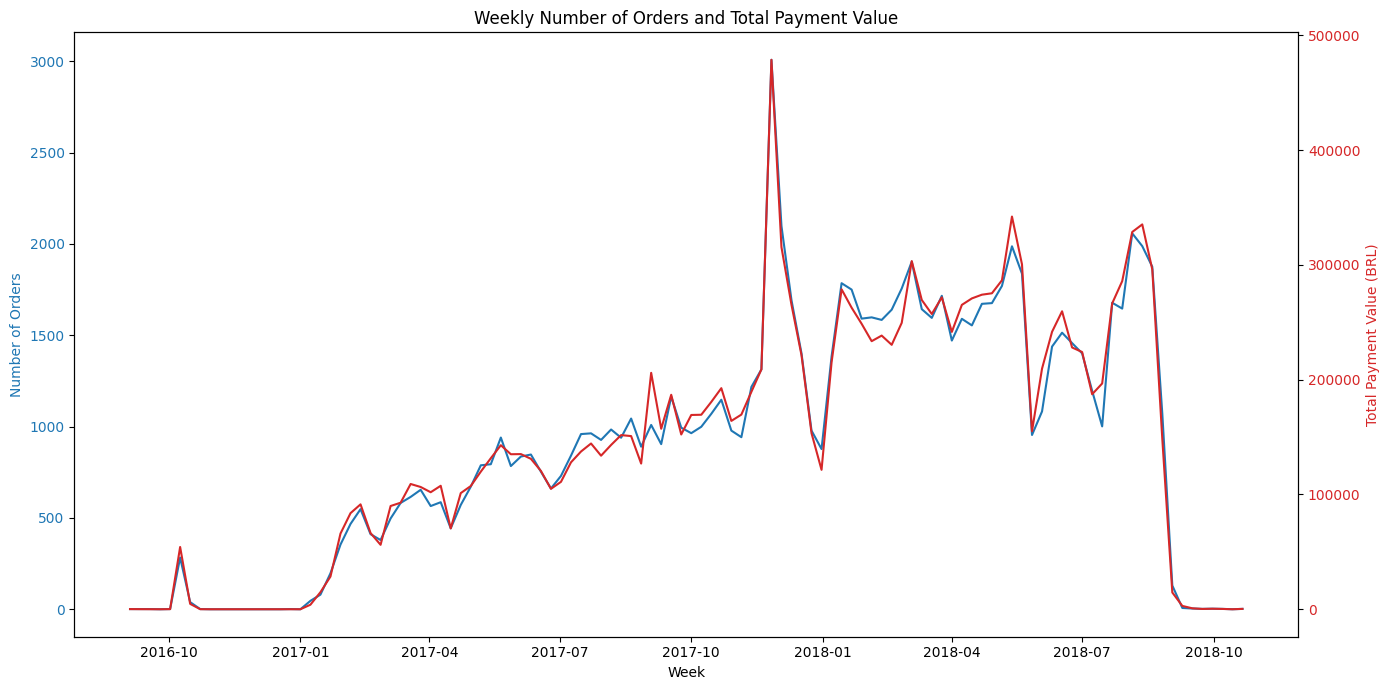

In [41]:
# Convert the 'order_purchase_timestamp' to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Merge the 'orders' DataFrame with 'order_payments' on 'order_id'
merged_df = pd.merge(orders, order_payments, on='order_id')

# Set the 'order_purchase_timestamp' as the index of the merged DataFrame
merged_df.set_index('order_purchase_timestamp', inplace=True)

# Resample the data to get weekly counts of orders and sums of 'payment_value'
weekly_orders = merged_df['order_id'].resample('W').nunique()
weekly_payment_values = merged_df['payment_value'].resample('W').sum()

# Plotting the weekly number of orders and total payment value
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of Orders', color=color)
ax1.plot(weekly_orders.index, weekly_orders.values, color=color, label='Number of Orders')
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Total Payment Value (BRL)', color=color)
ax2.plot(weekly_payment_values.index, weekly_payment_values.values, color=color, label='Total Payment Value')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Weekly Number of Orders and Total Payment Value')
fig.tight_layout()
plt.show()

📈 *(Optional)* Plot the weekly number of orders and payments again with techniques you learned during the `Data Visualization` module :)

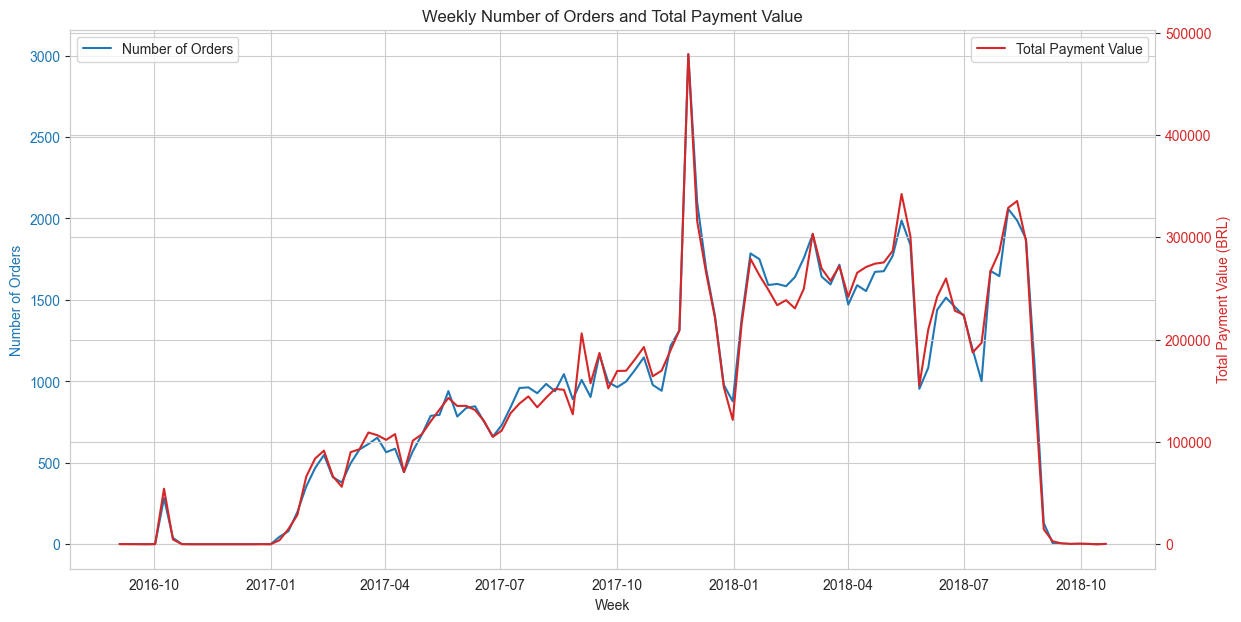

In [42]:
import seaborn as sns

# Set the style of the visualization
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the weekly number of orders
color = 'tab:blue'
sns.lineplot(x=weekly_orders.index, y=weekly_orders.values, color=color, ax=ax1, label='Number of Orders')
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of Orders', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the total payment value
ax2 = ax1.twinx()
color = 'tab:red'
sns.lineplot(x=weekly_payment_values.index, y=weekly_payment_values.values, color=color, ax=ax2, label='Total Payment Value')
ax2.set_ylabel('Total Payment Value (BRL)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Weekly Number of Orders and Total Payment Value')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

### Metric 2: Customer Satisfaction
❓ How does the `customer satisfaction` evolve on a monthly basis ? Use the mean average `review_score` to illustrate the customer satisfaction.

👉 Load the `reviews` :

In [43]:
# Loading the reviews dataset
reviews = data['order_reviews']

# Display the first few rows of the reviews dataset to understand its structure
print(reviews.head())

                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3           

⌛️ If you need to handle datetime, do it.

In [44]:
# Convert 'review_creation_date' to datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])

# Set the review creation date as the index
reviews.set_index('review_creation_date', inplace=True)

# Resample the data by month and calculate the mean review score
monthly_satisfaction = reviews['review_score'].resample('M').mean()

# Reset the index to turn the date back into a column
monthly_satisfaction = monthly_satisfaction.reset_index()

# Display the monthly satisfaction
print(monthly_satisfaction)

   review_creation_date  review_score
0            2016-10-31      4.055866
1            2016-11-30      3.188119
2            2016-12-31      2.355556
3            2017-01-31      4.338912
4            2017-02-28      4.280962
5            2017-03-31      4.033051
6            2017-04-30      4.036983
7            2017-05-31      4.100539
8            2017-06-30      4.127616
9            2017-07-31      4.183271
10           2017-08-31      4.224961
11           2017-09-30      4.182424
12           2017-10-31      4.182188
13           2017-11-30      4.114919
14           2017-12-31      3.931596
15           2018-01-31      4.063603
16           2018-02-28      4.014260
17           2018-03-31      3.727413
18           2018-04-30      3.919857
19           2018-05-31      4.193081
20           2018-06-30      4.197171
21           2018-07-31      4.288250
22           2018-08-31      4.209747


📉 Plot the customer satisfaction evolution over time

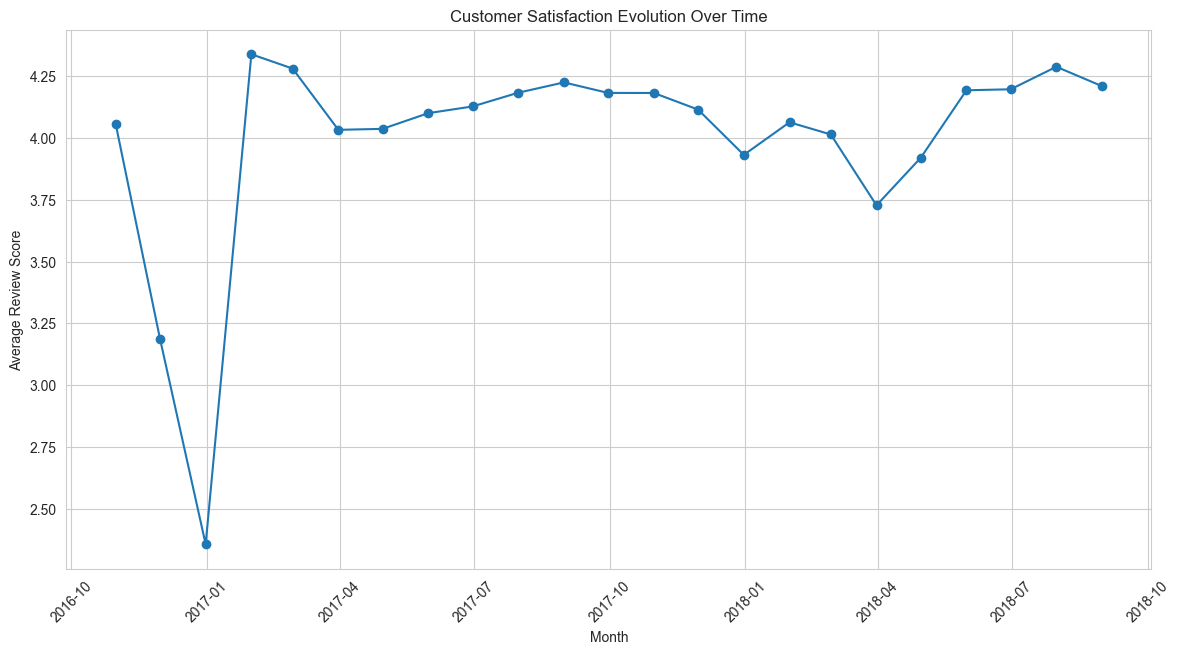

In [45]:
plt.figure(figsize=(14, 7))
plt.plot(monthly_satisfaction['review_creation_date'], monthly_satisfaction['review_score'], marker='o', linestyle='-')
plt.title('Customer Satisfaction Evolution Over Time')
plt.xlabel('Month')
plt.ylabel('Average Review Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

📉 *(Optional)* Plot the customer satisfaction evolution over time again with techniques you learned during the Data Visualization module :)

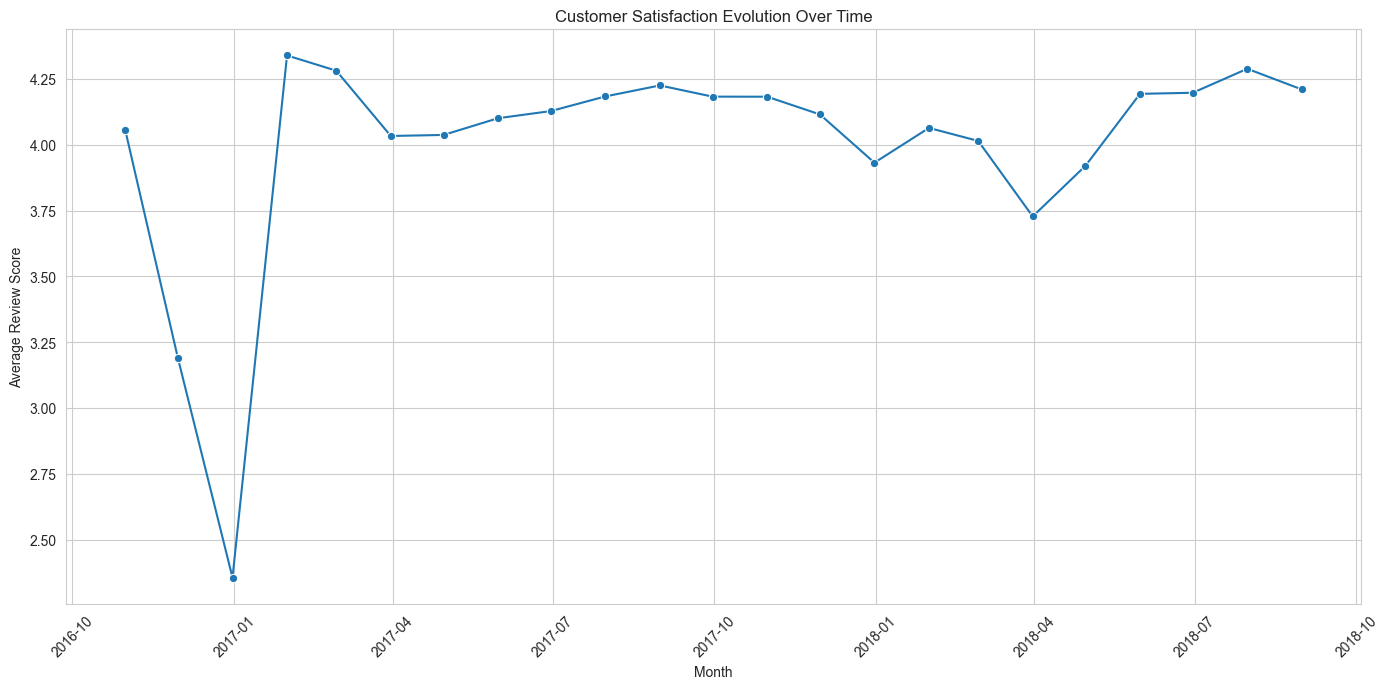

In [46]:
# Plotting the customer satisfaction evolution over time with Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_satisfaction, x='review_creation_date', y='review_score', marker='o')
plt.title('Customer Satisfaction Evolution Over Time')
plt.xlabel('Month')
plt.ylabel('Average Review Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

### Metric 3: Shipping delay

❓Create two new metrics, `delay_vs_expected` and `wait_time` in ***days***, from the `orders` dataset, and plot their historical evolution on a weekly basis to detect trends

<details>
    <summary>▸ <i>Hint</i></summary>

    
Ask `StackOverflow` to help you compute differences between `datetime`s in Python!
</details>

🛒 Let's focus on delivered orders so that we can compute the shipping delays:

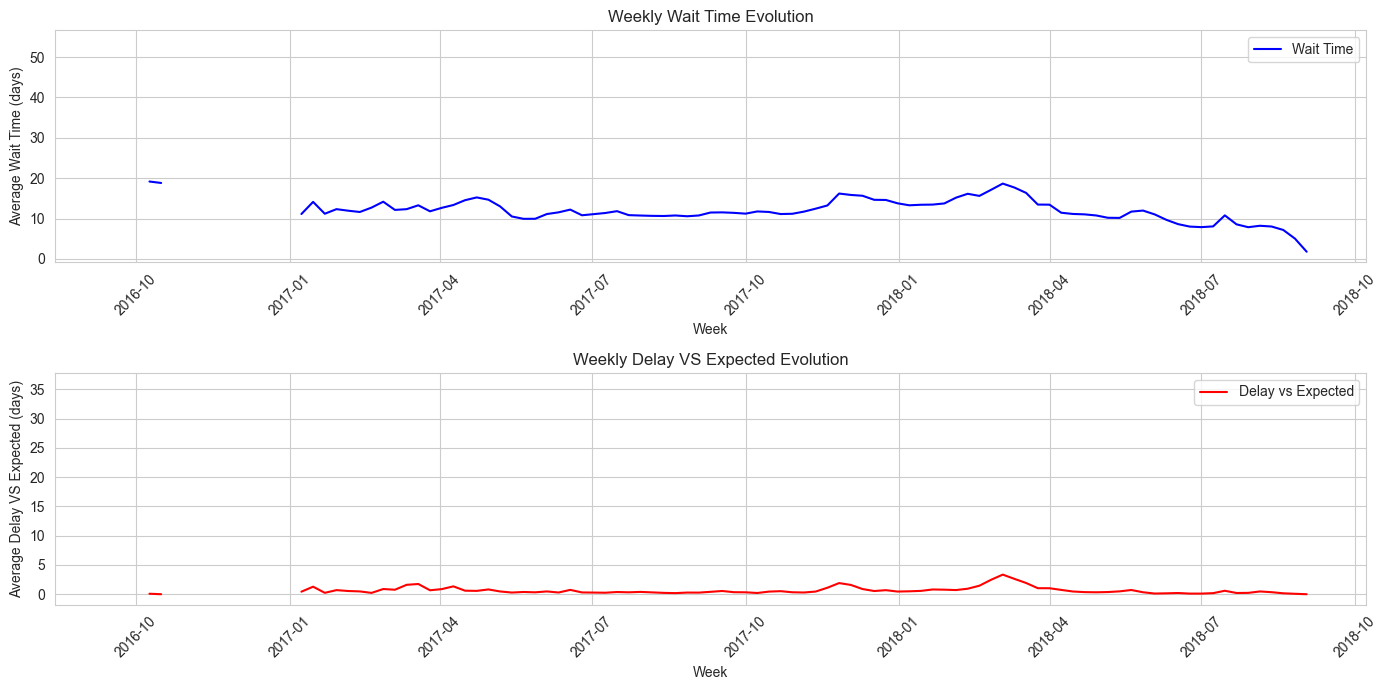

In [49]:
# Filter only delivered orders
delivered_orders = orders[orders['order_status'] == 'delivered'].copy()

# Convert date columns to datetime
delivered_orders.loc[:, 'order_purchase_timestamp'] = pd.to_datetime(delivered_orders['order_purchase_timestamp'])
delivered_orders.loc[:, 'order_estimated_delivery_date'] = pd.to_datetime(delivered_orders['order_estimated_delivery_date'])
delivered_orders.loc[:, 'order_delivered_customer_date'] = pd.to_datetime(delivered_orders['order_delivered_customer_date'])

# Compute wait_time in days
delivered_orders.loc[:, 'wait_time'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days

# Compute delay_vs_expected in days
delivered_orders.loc[:, 'delay_vs_expected'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_estimated_delivery_date']).dt.days

# Replace negative delays with 0 as it means delivered before expected
delivered_orders.loc[delivered_orders['delay_vs_expected'] < 0, 'delay_vs_expected'] = 0

# Resample to weekly frequency, aggregating with mean
weekly_wait_time = delivered_orders.resample('W', on='order_purchase_timestamp')['wait_time'].mean()
weekly_delay_vs_expected = delivered_orders.resample('W', on='order_purchase_timestamp')['delay_vs_expected'].mean()

# Plotting the metrics
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(weekly_wait_time.index, weekly_wait_time.values, label='Wait Time', color='blue')
plt.title('Weekly Wait Time Evolution')
plt.xlabel('Week')
plt.ylabel('Average Wait Time (days)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(weekly_delay_vs_expected.index, weekly_delay_vs_expected.values, label='Delay vs Expected', color='red')
plt.title('Weekly Delay VS Expected Evolution')
plt.xlabel('Week')
plt.ylabel('Average Delay VS Expected (days)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

⌛️ Datetime problems again ? Fix them ;)

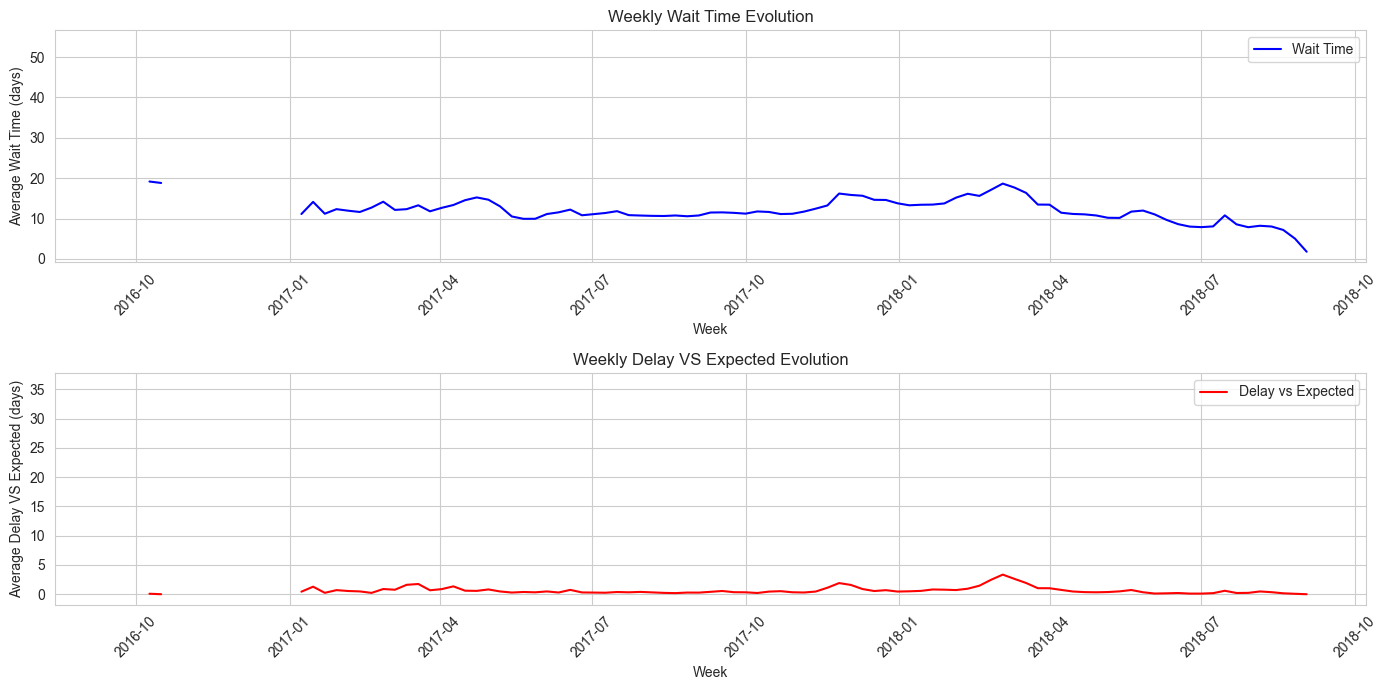

In [51]:
# Ensure datetime format
delivered_orders['order_purchase_timestamp'] = pd.to_datetime(delivered_orders['order_purchase_timestamp'])
delivered_orders['order_estimated_delivery_date'] = pd.to_datetime(delivered_orders['order_estimated_delivery_date'])
delivered_orders['order_delivered_customer_date'] = pd.to_datetime(delivered_orders['order_delivered_customer_date'])

# Calculate the metrics
delivered_orders['wait_time'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days
delivered_orders['delay_vs_expected'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_estimated_delivery_date']).dt.days

# Replace negative delays with 0 as it means delivered before expected
delivered_orders.loc[delivered_orders['delay_vs_expected'] < 0, 'delay_vs_expected'] = 0

# Plotting the metrics
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(weekly_wait_time.index, weekly_wait_time.values, label='Wait Time', color='blue')
plt.title('Weekly Wait Time Evolution')
plt.xlabel('Week')
plt.ylabel('Average Wait Time (days)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(weekly_delay_vs_expected.index, weekly_delay_vs_expected.values, label='Delay vs Expected', color='red')
plt.title('Weekly Delay VS Expected Evolution')
plt.xlabel('Week')
plt.ylabel('Average Delay VS Expected (days)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

👉 Compute the delay between the actual delivery date and the ETA for each order.

In [52]:
# Assuming 'delivered_orders' is your DataFrame with all the delivered orders.
# Ensure datetime format
delivered_orders['order_estimated_delivery_date'] = pd.to_datetime(delivered_orders['order_estimated_delivery_date'])
delivered_orders['order_delivered_customer_date'] = pd.to_datetime(delivered_orders['order_delivered_customer_date'])

# Calculate the delay
delivered_orders['delivery_delay'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_estimated_delivery_date']).dt.days

# If the delivery was before the ETA, we consider the delay as 0
delivered_orders['delivery_delay'] = delivered_orders['delivery_delay'].apply(lambda x: x if x > 0 else 0)

👉 Compute the waiting time between the actual delivery date and the moment a customer ordered their items

In [53]:
# Ensure datetime format
delivered_orders['order_purchase_timestamp'] = pd.to_datetime(delivered_orders['order_purchase_timestamp'])
delivered_orders['order_delivered_customer_date'] = pd.to_datetime(delivered_orders['order_delivered_customer_date'])

# Calculate the waiting time in days
delivered_orders['waiting_time'] = (delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']).dt.days

⌛️ How many orders were delivered later than expected ? <br/>
*You can also give an answer in terms of percentage if you prefer.*
<details>
    <summary><i>▸ Hint </i></summary>

    
You can create a `boolean_feature` which is :
* True when actual_delivered_date > ETA $\leftrightarrow$ actual_delivered_date - ETA > 0
* False otherwise
    
</details>




In [54]:
# Ensure datetime format
delivered_orders['order_estimated_delivery_date'] = pd.to_datetime(delivered_orders['order_estimated_delivery_date'])
delivered_orders['order_delivered_customer_date'] = pd.to_datetime(delivered_orders['order_delivered_customer_date'])

# Create a boolean feature
delivered_orders['delivered_late'] = (delivered_orders['order_delivered_customer_date'] > delivered_orders['order_estimated_delivery_date'])

# Count the number of orders delivered late
num_delivered_late = delivered_orders['delivered_late'].sum()

# Calculate the percentage of orders delivered late
percentage_delivered_late = (num_delivered_late / len(delivered_orders)) * 100

num_delivered_late, percentage_delivered_late

(7826, 8.111693857667031)

* On average, 8% of the orders are delivered after the ETA ⌛️

* Let's find which weeks were the worst 👇
    1. Aggregate the dataset per week
    2. Compute the percentage of orders delivered lately each week

In [55]:
# Convert the delivery date to the corresponding week
delivered_orders['week_of_year'] = delivered_orders['order_delivered_customer_date'].dt.isocalendar().week

# Group by week of the year
weekly_deliveries = delivered_orders.groupby('week_of_year').agg(
    total_orders=pd.NamedAgg(column='order_id', aggfunc='count'),
    late_orders=pd.NamedAgg(column='delivered_late', aggfunc='sum')
)

# Calculate the percentage of late orders per week
weekly_deliveries['percentage_late'] = (weekly_deliveries['late_orders'] / weekly_deliveries['total_orders']) * 100

# Sort the weeks by highest percentage of late orders
worst_weeks = weekly_deliveries.sort_values(by='percentage_late', ascending=False)

worst_weeks

,total_orders,late_orders,percentage_late
week_of_year,,,
1,1043,197,18.887824
14,2557,472,18.459132
52,1336,234,17.514970
15,2442,424,17.362817
16,2267,392,17.291575
13,2101,359,17.087101
51,1815,309,17.024793
12,2219,358,16.133393
2,1502,226,15.046605


📈 Plot the `number of delays` and `percentage of delayed orders` per week

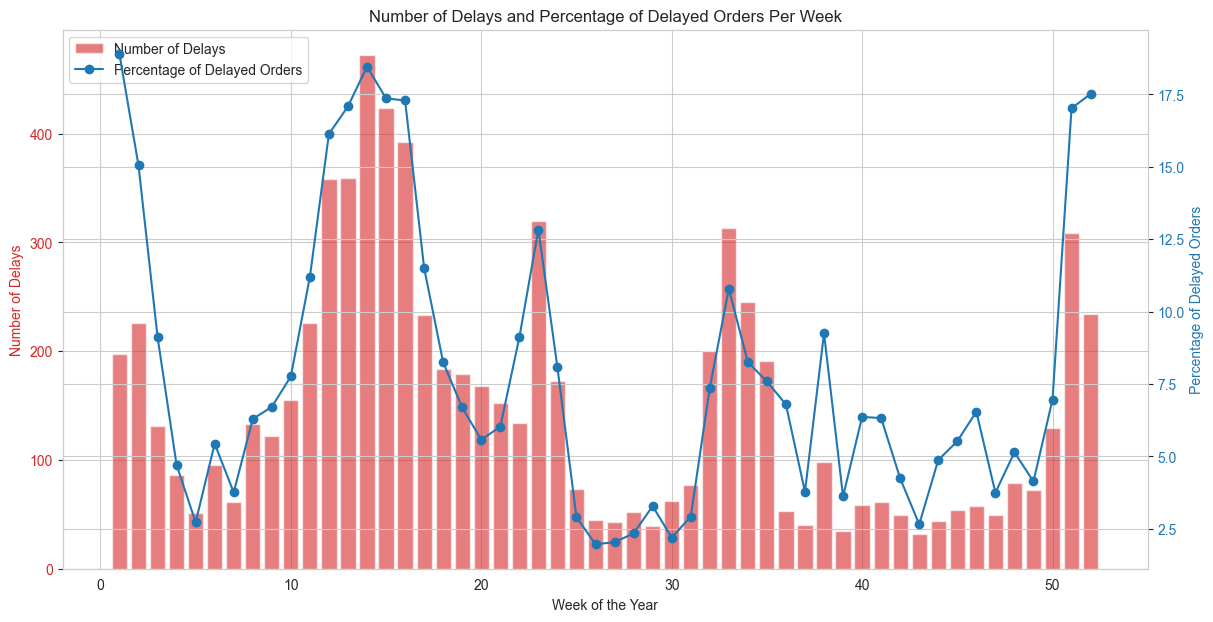

In [56]:
import matplotlib.pyplot as plt

# Ensure figures appear inline in the notebook
%matplotlib inline

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the number of delays
color = 'tab:red'
ax1.set_xlabel('Week of the Year')
ax1.set_ylabel('Number of Delays', color=color)
ax1.bar(weekly_deliveries.index, weekly_deliveries['late_orders'], color=color, alpha=0.6, label='Number of Delays')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()

# Plot the percentage of delayed orders
color = 'tab:blue'
ax2.set_ylabel('Percentage of Delayed Orders', color=color)
ax2.plot(weekly_deliveries.index, weekly_deliveries['percentage_late'], color=color, marker='o', label='Percentage of Delayed Orders')
ax2.tick_params(axis='y', labelcolor=color)

# Add a legend with a bit of layout
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show grid
ax1.grid(True)

# Show the plot
plt.title('Number of Delays and Percentage of Delayed Orders Per Week')
plt.show()

#### Delay Analysis

📈 📉 From the previous graph, Olist experienced major lateness issues on 3-4 weeks ⚠️...

👉 Let's deep dive into these peaks of lateness.

❓ Create a dataframe (with weeks as indexes ) with the following columns:
* number of delays
* number of orders
* percentage of delayed orders

In [58]:
import pandas as pd

# Convert the order purchase timestamps into datetime objects
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Add a new column to represent the week of the year
orders['week_of_year'] = orders['order_purchase_timestamp'].dt.isocalendar().week

# Define a function to determine if an order was delayed
def is_delayed(row):
    if pd.notnull(row['order_delivered_customer_date']) and pd.notnull(row['order_estimated_delivery_date']):
        return row['order_delivered_customer_date'] > row['order_estimated_delivery_date']
    else:
        return False

# Apply the function to each row
orders['is_delayed'] = orders.apply(is_delayed, axis=1)

# Group by week of the year
weekly_summary = orders.groupby('week_of_year').agg(
    number_of_delays=pd.NamedAgg(column='is_delayed', aggfunc='sum'),
    number_of_orders=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

# Calculate the percentage of delayed orders
weekly_summary['percentage_of_delayed_orders'] = (weekly_summary['number_of_delays'] / weekly_summary['number_of_orders']) * 100

# Set the week_of_year as the index
weekly_summary.set_index('week_of_year', inplace=True)

# Show the dataframe
print(weekly_summary)


              number_of_delays  number_of_orders  percentage_of_delayed_orders
week_of_year                                                                  
1                           55              1429                      3.848845
2                           84              1865                      4.504021
3                          132              1947                      6.779661
4                          139              1945                      7.146530
5                          138              2065                      6.682809
6                          164              2132                      7.692308
7                          242              2051                     11.799122
8                          381              2135                     17.845433
9                          565              2400                     23.541667
10                         466              2225                     20.943820
11                         393              2210    

❓ Create sub-dataframes to seperate these weeks into subgroups.

A suggestion:
- 20% and more
- 15-20%
- 10-15%
- 5-10%
- 5% and less

In [59]:
# Sub-dataframes based on the percentage of delayed orders
more_than_20_percent = weekly_summary[weekly_summary['percentage_of_delayed_orders'] >= 20]
between_15_and_20_percent = weekly_summary[(weekly_summary['percentage_of_delayed_orders'] >= 15) & (weekly_summary['percentage_of_delayed_orders'] < 20)]
between_10_and_15_percent = weekly_summary[(weekly_summary['percentage_of_delayed_orders'] >= 10) & (weekly_summary['percentage_of_delayed_orders'] < 15)]
between_5_and_10_percent = weekly_summary[(weekly_summary['percentage_of_delayed_orders'] >= 5) & (weekly_summary['percentage_of_delayed_orders'] < 10)]
less_than_5_percent = weekly_summary[weekly_summary['percentage_of_delayed_orders'] < 5]

# Display the subgroups
print("More than 20% delayed orders:")
print(more_than_20_percent)
print("\nBetween 15% and 20% delayed orders:")
print(between_15_and_20_percent)
print("\nBetween 10% and 15% delayed orders:")
print(between_10_and_15_percent)
print("\nBetween 5% and 10% delayed orders:")
print(between_5_and_10_percent)
print("\nLess than 5% delayed orders:")
print(less_than_5_percent)

More than 20% delayed orders:
              number_of_delays  number_of_orders  percentage_of_delayed_orders
week_of_year                                                                  
9                          565              2400                     23.541667
10                         466              2225                     20.943820

Between 15% and 20% delayed orders:
              number_of_delays  number_of_orders  percentage_of_delayed_orders
week_of_year                                                                  
8                          381              2135                     17.845433
11                         393              2210                     17.782805
47                         565              3008                     18.783245
48                         341              2098                     16.253575

Between 10% and 15% delayed orders:
              number_of_delays  number_of_orders  percentage_of_delayed_orders
week_of_year               